# Ajuste del modelo logísitico a datos de COVID-19

El propósito de este *notebook* es el de ajustar, utilizando un modelo logístico, los datos disponibles de casos confirmados y muertes del coronavirus COVID-19.

Este *notebook* puede ejecutarse dinámicamente con Binder:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/manuxch/logistic-covid19/master?filepath=Logistic_model_COVID-19.ipynb)

In [1]:
# Módulos necesarios
import csv  # manejo de archivos csv
import matplotlib.pyplot as plt  # gráficos
import matplotlib.cm as cm  # paletas de colores
from matplotlib.lines import Line2D  # markers
import requests  # accede a datos online
import numpy as np  # numpy!
from scipy.optimize import curve_fit  # ajuste de datos

## Acceso a datos

Los datos a utilizar son los provistos por el *Center for Systems Science and Engineering* (CSSE) de *Johns Hopkins University* (JHU), disponibles en su repositorio de [GitHub](https://github.com/CSSEGISandData/COVID-19). 

Los datos a ajustar son los de la cantidad de casos confirmados y el número de muertes.

In [2]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deadths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

r_cases = requests.get(url_cases)
r_deadths = requests.get(url_deadths)

## Selección y  extracción de datos por países

Los diccionarios siguientes agrupan los países que serán analizados según si son "cercanos" o "lejanos". Los datos en los archivos originales tienen la región en la primer columna y el país en la segunda. Por eso el diccionario está compuesto por una lista con dos elementos: región y país. La clave del diccionario es como se identifica al país en los datos originales, el segundo elemento de la lista es su nombre en español.

Los datos quedan agrupados en dos diccionarios, con las claves con el nombre del país, y los valores son array de datos.

In [3]:
paises_lat = {'Argentina': ['','Argentina'], 'Brasil': ['','Brazil'], 'Chile': ['','Chile'],
                'Ecuador': ['','Ecuador'], 'Perú': ['','Perú'], 'Colombia': ['','Colombia']}
paises_no_lat = {'Spain': ['','España'], 'Italy': ['','Italia'], 'United Kingdom': ['','Reino Unido'],
                 'US': ['','Estados Unidos'], 'Germany': ['','Alemania'], 'Korea, South': ['','Korea del Sur'],
                 'China':['Hubei','China-Hubei']}
cases_csv = csv.reader(r_cases.text.strip().split('\n'))
deadths_csv = csv.reader(r_deadths.text.strip().split('\n'))
cases_lat = {}
cases_no_lat = {}
for record in cases_csv:
    if record[1] in paises_lat.keys() and record[0] == paises_lat[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        cases_lat[paises_lat[record[1]][1]] = cases
    if record[1] in paises_no_lat.keys() and record[0] == paises_no_lat[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        cases_no_lat[paises_no_lat[record[1]][1]] = cases
deadths_lat = {}
deadths_no_lat = {}
for record in deadths_csv:
    if record[1] in paises_lat.keys() and record[0] == paises_lat[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        deadths_lat[paises_lat[record[1]][1]] = cases
    if record[1] in paises_no_lat.keys() and record[0] == paises_no_lat[record[1]][0]:
        cases = np.array([int(c) for c in record[4:]])
        deadths_no_lat[paises_no_lat[record[1]][1]] = cases

# Modelo de ajuste

El modelo de ajuste es el logístico. Este modelo representa la dinámica de una población que presenta un límite en el crecimiento, debido a disponibilidad limitada de recursos o, como en el caso de una población que sufre una epidemia, el aumento en la cantidad de personas contagiadas disminuye a medida que hay menos personas susceptibles de contraer el virus.

Puede verse una descripción detallada del modelo en el trabajo de Gábor Vattay: ["Predicting the ultimate outcome of the COVID-19 outbrak in Italy"](https://arxiv.org/abs/2003.07912) del 17 de marzo de 2020.

El modelo consiste en representar la dinámica de una población a través de la ecuación logística:
\begin{align}
\frac{dN(t)}{dt} = \lambda_0 \, N(t) \, \left(1 - \frac{N(t)}{N_{\infty}} \right)
\end{align}
donde $\lambda_0$ es un coeficiente relacionado con la tasa de crecimiento que depende de la cantidad de individuos de la población (ver ecuaciones 2 y 3 del *paper* citado), $N$ es la cantidad de individuos, $t$ es el tiempo, y $N_{\infty}$ en el valor límite que puede alcanzar la población.

La solución de la ecuación logística es:

\begin{align}
N(t) = \frac{N_{\infty}}{1 + \left( \frac{N_{\infty}}{N_0} - 1 \right) \, e^{- \lambda_0} t}
\end{align}
donde $N_0$ es el número de individuos de la población cuando $t=0$. En este *notebook*, $N$ puede representar tanto el número de casos confirmados como el número de personas fallecidas.

In [4]:
def logistic(t, Ninf, N0, lamb):
    return Ninf / (1.0 + (Ninf/N0 - 1.0) * np.exp(-lamb * t))

## Función de ajuste y visualización

Acá definimos una función que recibe el diccionario con datos a ajustar y visualizar, y un parámetro que indica el umbral de datos a partir del cual realizaremos el ajuste. Esta función se aplicará a los casos confirmados y muertes, para el conjunto de países latinoamericanos y no LATAM.

In [11]:
markers = Line2D.filled_markers
cmap = cm.get_cmap('brg')
def plot_fit(data, umbral, ylabel, logscale=True):
    ''' Función que genera un gráfico de los datos recibidos en data, y ajusta el 
    modelo logístico a partir de un umbral de valores. ylabel es una string para 
    identificar el eje vertical. Si logscale es False, se usa una escala lineal 
    en el eje vertical.
    
    El ajuste se muestra como línea en la visualización, y se presentan los valores
    obtenidos de N_inf y lambda, con la correspondiente desviación estándar.'''
    markers = Line2D.filled_markers
    colors = cmap(np.linspace(0, 1, len(data.keys())))
    fig, ax = plt.subplots(1,1, figsize=(12,10))
    iter = 0
    thres = umbral  # Valor de casos a partir de los que hago el ajuste
    for pais, valores in data.items():
        mask_t1 = (valores >= 1)  # para plotear solo desde que hay casos registrados
        time_1 = np.arange(valores[mask_t1].size)
        t1 = np.where(mask_t1 == True)[0][0]  # índice a partir de los cuales tengo datos >= 1
        mask_fit = (valores >= thres)  # para seleccionar para el ajuste solo los valores >= thres
        time_fit = np.arange(valores[mask_fit].size)  # índice a partir de los cuales tengo datos >= 1
        tThres = np.where(mask_fit == True)[0][0]  # índice a partir de los cuales tengo datos >= thres
        try:
            popt, pcov = curve_fit(logistic, time_fit, valores[mask_fit], method='lm')
            stde = np.sqrt(np.diag(pcov))
            print(80 * '-')
            print(pais)
            print('N_inf:', int(popt[0]), '+/-', int(stde[0]), '(1 sigma)')
            print('lambda: {:.3f} +/- {:.3f} (1 sigma)'.format(popt[2], stde[2]))
            ax.plot(time_1, valores[mask_t1], marker=markers[iter], color=colors[iter], lw=0, label=pais, alpha=0.7)
            ax.plot(time_fit + tThres - t1, logistic(time_fit, *popt), '-', color=colors[iter], lw=2)
        except:
            print(f'No hay convergencia para {pais}') 
        iter += 1
    if logscale:
        plt.semilogy()
    plt.xlabel('Días desde el primer caso')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## Número de casos confirmados

El número de casos confirmados se obtiene a partir de los test que se le realizan a las personas. Cada país tiene políticas diferentes para aplicar estos tests. Tal vez el país que masivamente ha evaluado a su población sea Corea del Sur. Dado que no se evalúa a toda la población, este número está subestimado.

## Países no latinoamericanos

--------------------------------------------------------------------------------
China-Hubei
N_inf: 67736 +/- 346 (1 sigma)
lambda: 0.235 +/- 0.008 (1 sigma)
--------------------------------------------------------------------------------
Alemania
N_inf: 86170 +/- 8412 (1 sigma)
lambda: 0.237 +/- 0.012 (1 sigma)
--------------------------------------------------------------------------------
Italia
N_inf: 119288 +/- 2665 (1 sigma)
lambda: 0.194 +/- 0.003 (1 sigma)
--------------------------------------------------------------------------------
Korea del Sur
N_inf: 8723 +/- 79 (1 sigma)
lambda: 0.289 +/- 0.013 (1 sigma)
--------------------------------------------------------------------------------
España
N_inf: 168435 +/- 23952 (1 sigma)
lambda: 0.220 +/- 0.009 (1 sigma)
--------------------------------------------------------------------------------
Reino Unido
N_inf: 101769 +/- 64846 (1 sigma)
lambda: 0.210 +/- 0.011 (1 sigma)
--------------------------------------------------------

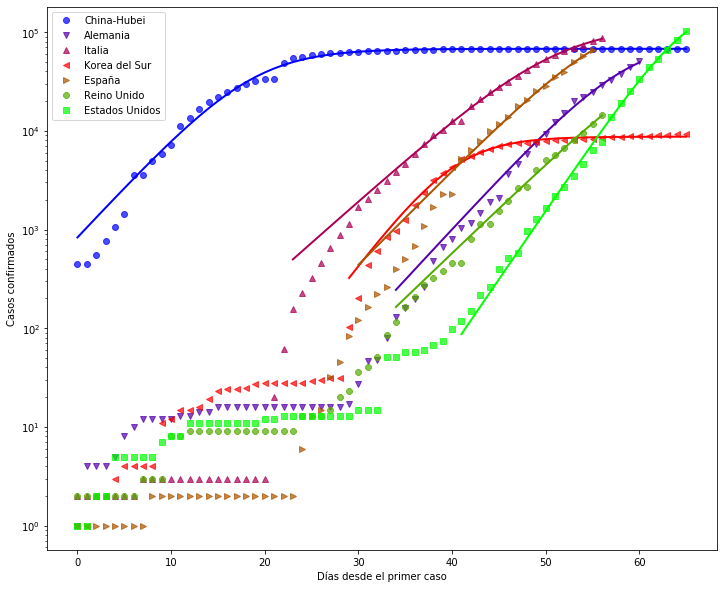

In [12]:
plot_fit(cases_no_lat, 100, 'Casos confirmados')

## Países latinoamericanos

--------------------------------------------------------------------------------
Argentina
N_inf: 1043 +/- 247 (1 sigma)
lambda: 0.294 +/- 0.034 (1 sigma)
--------------------------------------------------------------------------------
Chile
N_inf: 3416 +/- 662 (1 sigma)
lambda: 0.273 +/- 0.019 (1 sigma)
--------------------------------------------------------------------------------
Colombia
N_inf: 752 +/- 79 (1 sigma)
lambda: 0.351 +/- 0.032 (1 sigma)
--------------------------------------------------------------------------------
Ecuador
N_inf: 1674 +/- 100 (1 sigma)
lambda: 0.505 +/- 0.051 (1 sigma)


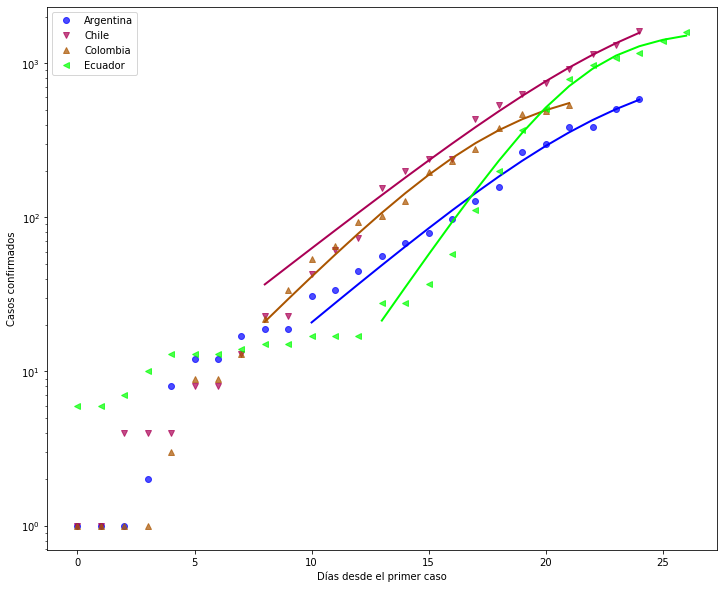

In [13]:
plot_fit(cases_lat, 20, 'Casos confirmados')

## Número de muertes registradas

El número de personas fallecidas por el COVID-19 se registra con mayore precisión, por lo que sus números son mas confiables que el de los casos confirmados. A continuación hacemos el ajuste del modelo logístico sobre estos datos.

### Países no latinoamericanos

--------------------------------------------------------------------------------
China-Hubei
N_inf: 3121 +/- 10 (1 sigma)
lambda: 0.154 +/- 0.002 (1 sigma)
--------------------------------------------------------------------------------
Alemania
N_inf: 10158319160 +/- 23324768504314428 (1 sigma)
lambda: 0.249 +/- 0.008 (1 sigma)
--------------------------------------------------------------------------------
Italia
N_inf: 13531 +/- 451 (1 sigma)
lambda: 0.217 +/- 0.005 (1 sigma)
--------------------------------------------------------------------------------
Korea del Sur
N_inf: 395 +/- 115 (1 sigma)
lambda: 0.071 +/- 0.006 (1 sigma)
--------------------------------------------------------------------------------
España
N_inf: 11366 +/- 849 (1 sigma)
lambda: 0.298 +/- 0.008 (1 sigma)
--------------------------------------------------------------------------------
Reino Unido
N_inf: 2901 +/- 2602 (1 sigma)
lambda: 0.246 +/- 0.037 (1 sigma)
-----------------------------------------------

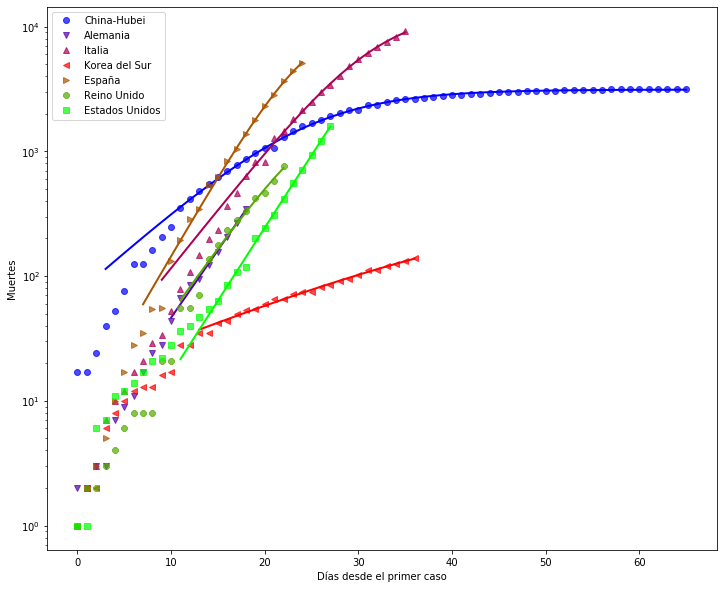

In [8]:
plot_fit(deadths_no_lat, 30, 'Muertes')

### Países latinoamericanos

Para los países latinoamericanos, la cantidad de fallecidos es baja (**afortunadamente**), y por lo tanto aún hay muy pocos datos para realizar ajustes precisos.

--------------------------------------------------------------------------------
Argentina
N_inf: 365972802 +/- 2068812126282539 (1 sigma)
lambda: 0.190 +/- 0.033 (1 sigma)
--------------------------------------------------------------------------------
Chile
N_inf: 10432426 +/- 18314896346281 (1 sigma)
lambda: 0.261 +/- 0.157 (1 sigma)
--------------------------------------------------------------------------------
Colombia
N_inf: 10 +/- 10 (1 sigma)
lambda: 0.366 +/- 0.257 (1 sigma)
--------------------------------------------------------------------------------
Ecuador
N_inf: 39 +/- 2 (1 sigma)
lambda: 0.595 +/- 0.065 (1 sigma)


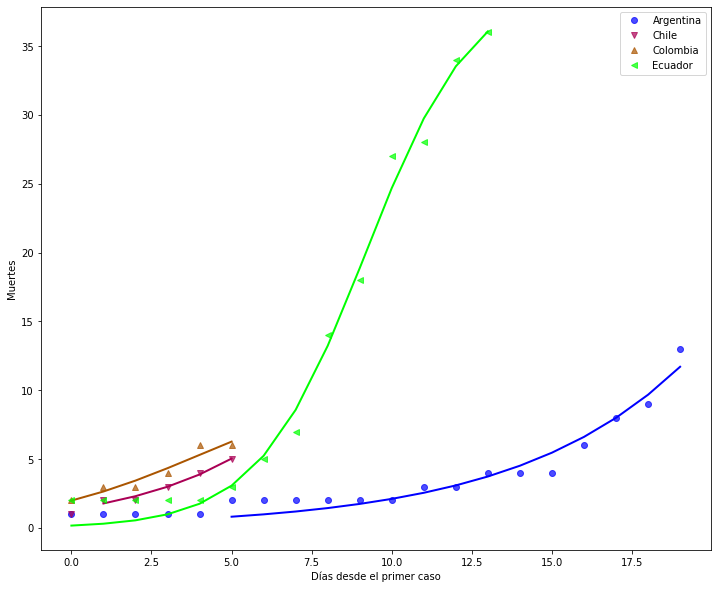

In [14]:
plot_fit(deadths_lat, 2, 'Muertes', logscale=False)